In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import rcParams

# 设置中文字体支持
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

### 原始连续信号
$$f(t)=\sin(2\pi f_1 t)+0.5\cdot\sin(2\pi f_2 t)$$

In [47]:
def generate_original_signal(t):
    """生成原始连续信号: f(t) = sin(2*pi*f1*t) + 0.5*sin(2*pi*f2*t)"""
    f1, f2 = 1.0, 2.0  # 信号频率
    return np.sin(2*np.pi*f1*t) + 0.5*np.sin(2*np.pi*f2*t)


### 可视化原始信号

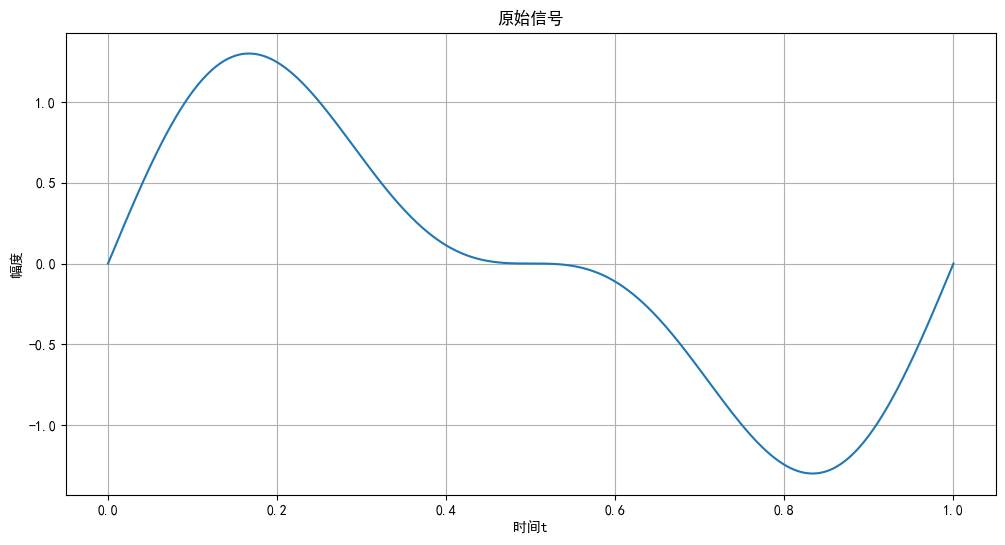

In [48]:
plt.figure(figsize=(12, 6))
t = np.linspace(0, 1, 1000)
f = generate_original_signal(t)
plt.plot(t, f)
plt.title("原始信号")
plt.xlabel("时间t")
plt.ylabel("幅度")
plt.grid(True)
plt.show()

### 方法1：通过理想低通滤波器重建
$$y(t)=\Sigma x(nT)\frac{sin[\pi (\frac{t}{T-n})]}{\pi (\frac{t}{T-n})}$$
### 方法2：通过傅里叶变换重建
$$x(t)=\frac{1}{2\pi}\Sigma Tx(nT)\int^{\frac{\pi}{T}}_{-\frac{\pi}{T}}e^{j\Omega (t-nT)}d\Omega$$

In [49]:
def sample_signal(t, x, Ts):
    """对信号进行采样"""
    n = np.arange(0, len(t), int(Ts * len(t) / t[-1]))
    return t[n], x[n]

def reconstruct_lowpass(t, samples, sample_times, T):
    """方法1：通过理想低通滤波器重建
    y(t) = Σ x(nT)sin[π(t/T-n)]/(π(t/T-n))
    """
    y = np.zeros_like(t)
    for i, t_i in enumerate(t):
        # 实现公式(1.93)
        sinc_sum = np.sum(samples * np.sinc((t_i - sample_times)/T))
        y[i] = sinc_sum
    return y

def reconstruct_fourier(t, samples, sample_times, T):
    """方法2：通过傅里叶变换重建
    x(t) = 1/2π Σ Tx(nT) ∫[-π/T to π/T] e^(jΩ(t-nT)) dΩ
    """
    y = np.zeros_like(t)
    omega_max = np.pi/T
    num_points = 1000  # Number of points for numerical integration
    omega = np.linspace(-omega_max, omega_max, num_points)
    dw = 2 * omega_max / (num_points - 1)
    
    for i, t_i in enumerate(t):
        # For each time point, compute the Fourier integral
        integral_sum = 0
        for n, (sample, sample_time) in enumerate(zip(samples, sample_times)):
            # Numerical integration using trapezoidal rule
            integrand = np.exp(1j * omega * (t_i - sample_time))
            integral = np.sum(integrand) * dw
            integral_sum += sample * T * integral

        y[i] = integral_sum / (2 * np.pi)
    return np.real(y)  # Take real part as result should be real

In [50]:
# 设置参数
duration = 5.0  # 信号持续时间
fs = 5        # 采样频率
T = 1/fs        # 采样周期
t = np.linspace(0, duration, 1000)  # 连续时间点
x = generate_original_signal(t)      # 生成原始信号

# 采样
t_samples, x_samples = sample_signal(t, x, T)

# 重建
y_lowpass = reconstruct_lowpass(t, x_samples, t_samples, T)
y_fourier = reconstruct_fourier(t, x_samples, t_samples, T)


/var/folders/f_/zgh1n7tj6wqcgk47sst4brvw0000gn/T/ipykernel_19092/647084532.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i] = integral_sum / (2 * np.pi)


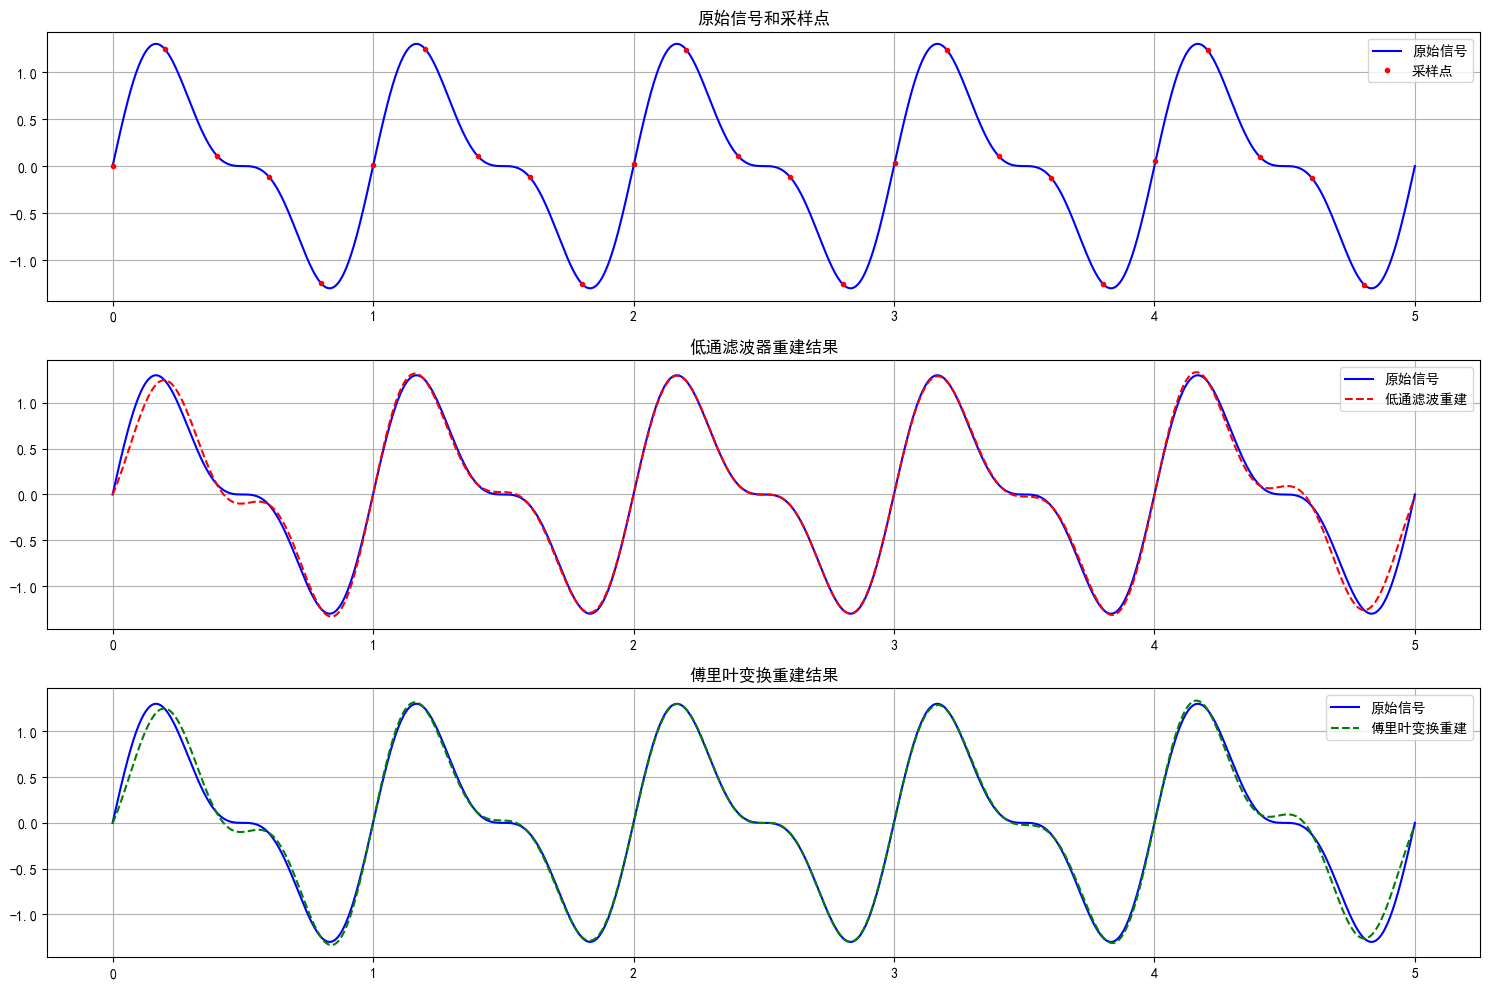

In [51]:
# 可视化
plt.figure(figsize=(15, 10))

# 原始信号和采样点
plt.subplot(311)
plt.plot(t, x, 'b-', label='原始信号')
plt.plot(t_samples, x_samples, 'r.', label='采样点')
plt.grid(True)
plt.legend()
plt.title('原始信号和采样点')

# 低通滤波器重建
plt.subplot(312)
plt.plot(t, x, 'b-', label='原始信号')
plt.plot(t, y_lowpass, 'r--', label='低通滤波重建')
plt.grid(True)
plt.legend()
plt.title('低通滤波器重建结果')

# 傅里叶变换重建
plt.subplot(313)
plt.plot(t, x, 'b-', label='原始信号')
plt.plot(t, y_fourier, 'g--', label='傅里叶变换重建')
plt.grid(True)
plt.legend()
plt.title('傅里叶变换重建结果')

plt.tight_layout()
plt.show()


In [52]:
# 计算重建误差
error_lowpass = np.mean(np.abs(x - y_lowpass))
error_fourier = np.mean(np.abs(x - y_fourier))

print(f'低通滤波重建平均误差: {error_lowpass:.6f}')
print(f'傅里叶变换重建平均误差: {error_fourier:.6f}')


低通滤波重建平均误差: 0.037607
傅里叶变换重建平均误差: 0.037939


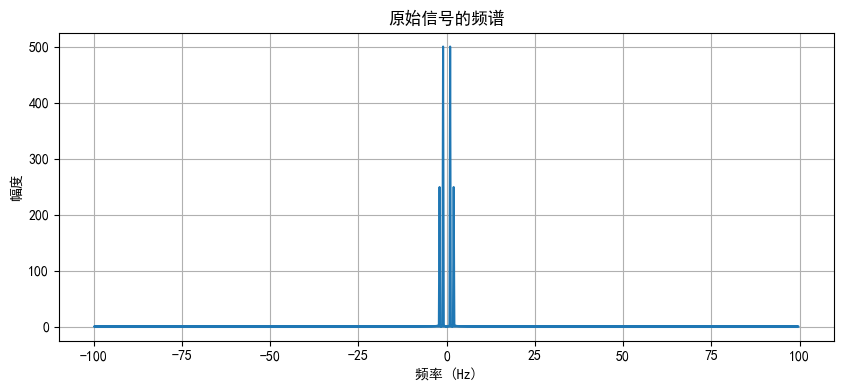

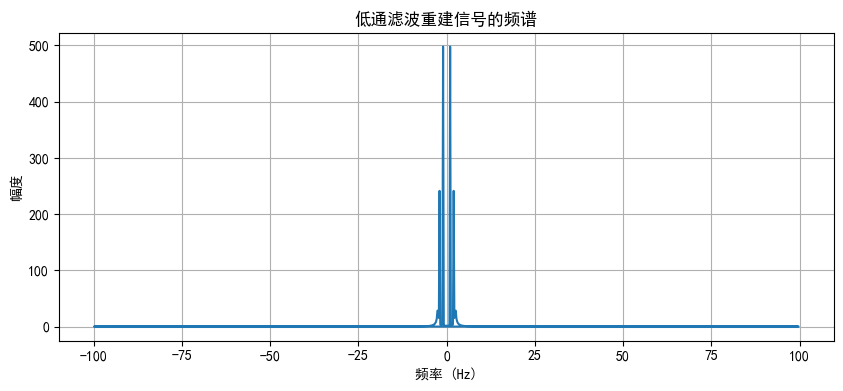

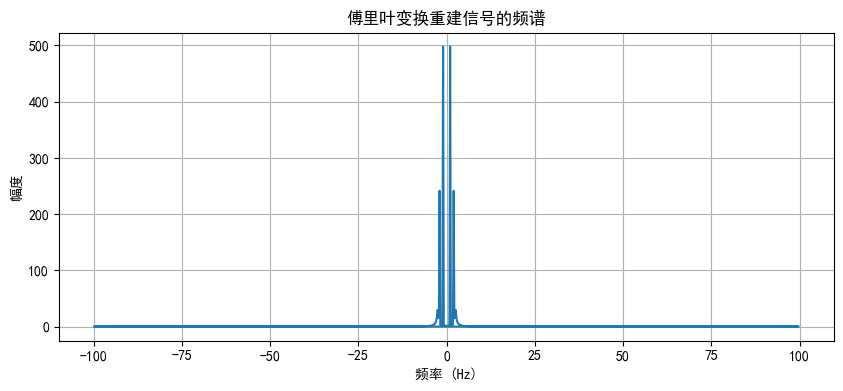

In [53]:
# 频谱分析
def plot_spectrum(t, signal, title):
    freq = np.fft.fftfreq(len(t), t[1]-t[0])
    spectrum = np.abs(np.fft.fft(signal))
    
    plt.figure(figsize=(10, 4))
    plt.plot(freq, spectrum)
    plt.title(f'{title}的频谱')
    plt.xlabel('频率 (Hz)')
    plt.ylabel('幅度')
    plt.grid(True)
    plt.show()

# 显示各信号的频谱
plot_spectrum(t, x, '原始信号')
plot_spectrum(t, y_lowpass, '低通滤波重建信号')
plot_spectrum(t, y_fourier, '傅里叶变换重建信号')